FixMatch: https://arxiv.org/ftp/arxiv/papers/2001/2001.07685.pdf
AutoAugment:https://towardsdatascience.com/how-to-improve-your-image-classifier-with-googles-autoaugment-77643f0be0c9 
https://arxiv.org/pdf/1805.09501.pdf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/MLDL/semi-inat-2021.zip /
!unzip -qq /semi-inat-2021.zip

### Dataset

In [ ]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import random
l_train_path = './l_train'
u_train_path = './u_train'
val_path = './val'
test_path = './test'
classes = 810
max_width = 300
max_length = 300

input_size = 224

## Image Transforms

##following are required 
# this one is to convert to pytorch format 
to_pytorch_tensor = transforms.Compose([
        transforms.PILToTensor(),
        
])

# some images are not 3 channels
to_3channels = transforms.Compose([
        transforms.Lambda(lambda x: x.repeat(3,1,1))
        ])
    
#for l_train and val
#there are 810 folders from 0 to 809
#will return image and label
#if use the default transfrom, image will be a pytorch tensor
#pass use_memory = False, if ran out of ram
class iNat_dataset_labeled(Dataset):
    def __init__(self, 
                 data_type, 
                 tf = None):
      self.data_type = data_type
      if self.data_type == 'l_train':
        self.data_dir = os.path.join(l_train_path, 'l_train')
      elif self.data_type == 'val':
        self.data_dir = os.path.join(val_path, 'val')
      #if load all data into memeory
      self.transform = tf
      self.data = []
      self.labels = []
      for i in range(classes):
        path = os.path.join(self.data_dir, str(i))
        images = os.listdir(path)
        for j in range(len(images)):
          img = os.path.join(path, images[j])
          img = Image.open(img)
          self.data.append(img)
          self.labels.append(i)

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, idx):
      img = self.data[idx]
      img = to_pytorch_tensor(img)
      if img.size(0) != 3:
        img = to_3channels(img)
      if self.transform:
        img = self.transform(img)
      
      return img, self.labels[idx]

#for u_train and test
#return image and its file name 
class iNat_dataset_unlabeled(Dataset):
    def __init__(self, 
                 data_type, 
                 tf = None):
      self.data_type = data_type
      if self.data_type == 'u_train':
        self.data_dir = os.path.join(u_train_path, 'u_train')
      elif self.data_type == 'test':
        self.data_dir = os.path.join(test_path, 'test')

      self.transform = tf
      self.data = []
      self.names = []

      images = os.listdir(self.data_dir)
      for i in range(len(images)):
        path = os.path.join(self.data_dir, images[i])
        self.data.append(path)
        self.names.append(images[i])

    def __len__(self):
      return len(self.names)

    def __getitem__(self, idx):
      img = Image.open(self.data[idx])
      img = to_pytorch_tensor(img)

      if img.size(0) != 3:
        if img.size(0) == 1:
          img = to_3channels(img)
        else:
          idx = 0
          path = os.path.join(u_train_path, 'u_train', self.names[idx])
          img = Image.open(path)
          img = to_pytorch_tensor(img)

      if self.transform:
        img = self.transform(img)
      
      return img

Augmentations

In [ ]:
mean,std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

weak_img_augmentation = transforms.Compose([                                            
        transforms.RandomHorizontalFlip(0.5),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean,std),
])
strong_img_augmentation = transforms.Compose([
        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean,std),
])
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean,std)
])
test_transform = transforms.Compose([
        transforms.Resize([input_size,input_size]),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean,std)
])

u_preprocess = transforms.Compose([                         
        transforms.RandomResizedCrop(input_size)])

In [ ]:
l_train_dataset=iNat_dataset_labeled(data_type="l_train", tf=train_transform)
val_dataset=iNat_dataset_labeled(data_type="val", tf=test_transform)

In [ ]:
test_dataset=iNat_dataset_unlabeled(data_type="test", tf=test_transform)
u_train_dataset=iNat_dataset_unlabeled(data_type="u_train", tf=u_preprocess)

### Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import gc

In [ ]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/MLDL/saved_models/FixMatch_warmup.pth'))
gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

## Clean cache

In [ ]:
del labeled_data, labeled_target, unlabeled_data, l_output, labeled_loss, u_data_s, u_s_output, loss, unlabeded_loss, mask

In [ ]:
gc.collect()
torch.cuda.empty_cache()

## Train

In [ ]:
best_est_acc = 0.3851851851851852

In [ ]:
batch_size = 25 #125 for unlabeled dataset so total is 150
#ratio of unlabeled data to use
ratio = 5 
#confidence threshold for pseudo label
threshold = 0.8
#weight of unlabeled data loss
weight = 2

lr = 0.003
total_epochs = 50

criterion = nn.CrossEntropyLoss()
unlabeded_criterion = nn.CrossEntropyLoss(reduction='none')
#optimizer = optim.Adam(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.5)

optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=0.0003)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 50)

l_train_dataloader = DataLoader(l_train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
u_train_dataloader = DataLoader(u_train_dataset, batch_size=batch_size*ratio, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

epoch: 1  train loss: 3.814413380806734 val accuracy: 0.1908641975308642
ETA of completion: 403.125409813722 minutes
epoch: 2  train loss: 3.030545669227149 val accuracy: 0.22839506172839505
ETA of completion: 387.3246192932129 minutes
epoch: 3  train loss: 2.6328303449258095 val accuracy: 0.25333333333333335
ETA of completion: 370.996461657683 minutes
epoch: 4  train loss: 2.442999810057005 val accuracy: 0.25012345679012343
ETA of completion: 357.4993728001912 minutes
epoch: 5  train loss: 2.266208349279389 val accuracy: 0.26395061728395064
ETA of completion: 351.63579136133194 minutes
epoch: 6  train loss: 2.1309053355440075 val accuracy: 0.2812345679012346
ETA of completion: 344.8610778808594 minutes
epoch: 7  train loss: 2.0299459453720052 val accuracy: 0.29555555555555557
ETA of completion: 334.34755593538284 minutes
epoch: 8  train loss: 1.9160042688595298 val accuracy: 0.3128395061728395
ETA of completion: 326.1120794296265 minutes
epoch: 9  train loss: 1.7699653339263406 val ac

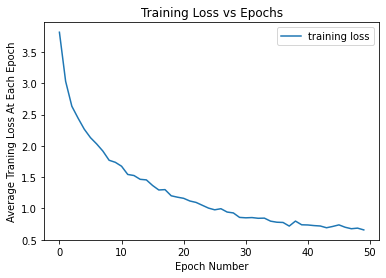

In [ ]:
train_loss = []
best_acc = 0
for epoch in range(total_epochs):
  time1 = time.time()

  #train
  model.train()
  unlabeled_iter = iter(u_train_dataloader)
  optimizer.zero_grad()

  total_loss = 0
  for i, (labeled_data, labeled_target) in enumerate(l_train_dataloader):
    unlabeled_data = next(unlabeled_iter)
    if gpu_boole:
      labeled_data, labeled_target = labeled_data.cuda(), labeled_target.cuda()
      unlabeled_data = unlabeled_data.cuda()
    
    
    #labeled loss
    l_output = model(labeled_data)
    labeled_loss = criterion(l_output, labeled_target)

    #unlabeded loss
    
    u_data_w = weak_img_augmentation(unlabeled_data)
    u_w_output = torch.softmax(model(u_data_w).detach(), dim=-1)
    probs, pseudo_labels = torch.max(u_w_output, 1)
    mask = probs.ge(threshold).float()
    u_data_s = strong_img_augmentation(unlabeled_data)
    u_s_output = model(u_data_s)
    unlabeded_loss = (unlabeded_criterion(u_s_output, pseudo_labels)*mask).mean()

    loss = labeled_loss+weight*unlabeded_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  scheduler.step()
  train_loss.append(total_loss/len(l_train_dataloader))
  gc.collect()
  
  #val
  #approximate because use 224x244 instead of nx224 or 224xn for 
  #large test batch and faster testing
  model.eval()
  correct_sum = 0
  with torch.no_grad():
    for data, target in val_dataloader:
      if gpu_boole:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      _, predicted = torch.max(output.data, 1)
      correct_sum += (predicted.float() == target.float()).sum().item()
  time2 = time.time()

  val_acc = correct_sum/len(val_dataset)
  print('epoch:', epoch+1, ' train loss:', total_loss/len(l_train_dataloader), \
        'val accuracy:', val_acc)
  print('ETA of completion:',(time2 - time1)*(total_epochs - epoch - 1)/60,'minutes')
  if val_acc > best_est_acc and best_acc < val_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), '/content/drive/MyDrive/MLDL/saved_models/FixMatch_bestsofar.pth')

plt.plot(train_loss, label = 'training loss')
plt.xlabel('Epoch Number')
plt.ylabel('Average Traning Loss At Each Epoch')
plt.legend()
plt.title('Training Loss vs Epochs')
plt.show()

Overfitting test and try to obtain the best model. Got a better gpu here 

In [ ]:
batch_size = 50 #250 for unlabeled dataset so total is 300
#ratio of unlabeled data to use
ratio = 5 
#confidence threshold for pseudo label
threshold = 0.7
#weight of unlabeled data loss
weight = 2

lr = 1e-8
total_epochs = 50

criterion = nn.CrossEntropyLoss()
unlabeded_criterion = nn.CrossEntropyLoss(reduction='none')
#optimizer = optim.Adam(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.5)

optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=0.0003)
state_dict = torch.load('/content/drive/MyDrive/MLDL/saved_models/FixMatch_model1.pth') 
model.load_state_dict(state_dict)
state_dict1 = torch.load('/content/drive/MyDrive/MLDL/saved_models/FixMatch_optimizer1.pth')
optimizer.load_state_dict(state_dict1)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 50)

l_train_dataloader = DataLoader(l_train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
u_train_dataloader = DataLoader(u_train_dataset, batch_size=batch_size*ratio, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

epoch: 1  train loss: 0.8034511716702045 val accuracy: 0.3718518518518519
ETA of completion: 203.68455360730488 minutes
epoch: 2  train loss: 0.8176826261557065 val accuracy: 0.3708641975308642
ETA of completion: 204.63511257171632 minutes
epoch: 3  train loss: 0.8308995035978464 val accuracy: 0.37333333333333335
ETA of completion: 196.24851641257604 minutes
epoch: 4  train loss: 0.8311638934490008 val accuracy: 0.37703703703703706
ETA of completion: 193.09086649417878 minutes
epoch: 5  train loss: 0.8655814878451519 val accuracy: 0.3844444444444444
ETA of completion: 190.3624198436737 minutes
epoch: 6  train loss: 0.800353732246619 val accuracy: 0.37777777777777777
ETA of completion: 183.77097047170002 minutes
epoch: 7  train loss: 0.8355591145081398 val accuracy: 0.3819753086419753
ETA of completion: 178.89906642834345 minutes
epoch: 8  train loss: 0.7801758760061019 val accuracy: 0.37061728395061727
ETA of completion: 176.73638253211976 minutes
epoch: 9  train loss: 0.82788473237783

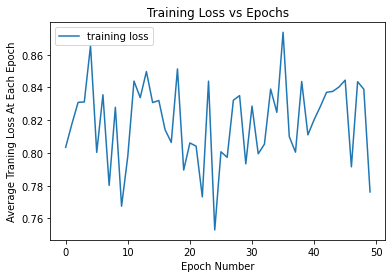

In [ ]:
train_loss = []
best_acc = 0
for epoch in range(total_epochs):
  time1 = time.time()

  #train
  model.train()
  unlabeled_iter = iter(u_train_dataloader)
  optimizer.zero_grad()

  total_loss = 0
  for i, (labeled_data, labeled_target) in enumerate(l_train_dataloader):
    unlabeled_data = next(unlabeled_iter)
    if gpu_boole:
      labeled_data, labeled_target = labeled_data.cuda(), labeled_target.cuda()
      unlabeled_data = unlabeled_data.cuda()
    
    
    #labeled loss
    l_output = model(labeled_data)
    labeled_loss = criterion(l_output, labeled_target)

    #unlabeded loss
    
    u_data_w = weak_img_augmentation(unlabeled_data)
    u_w_output = torch.softmax(model(u_data_w).detach(), dim=-1)
    probs, pseudo_labels = torch.max(u_w_output, 1)
    mask = probs.ge(threshold).float()
    u_data_s = strong_img_augmentation(unlabeled_data)
    u_s_output = model(u_data_s)
    unlabeded_loss = (unlabeded_criterion(u_s_output, pseudo_labels)*mask).mean()

    loss = labeled_loss+weight*unlabeded_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  scheduler.step()
  train_loss.append(total_loss/len(l_train_dataloader))
  gc.collect()
  
  #val
  #approximate because use 224x244 instead of nx224 or 224xn for 
  #large test batch and faster testing
  model.eval()
  correct_sum = 0
  with torch.no_grad():
    for data, target in val_dataloader:
      if gpu_boole:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      _, predicted = torch.max(output.data, 1)
      correct_sum += (predicted.float() == target.float()).sum().item()
  time2 = time.time()

  val_acc = correct_sum/len(val_dataset)
  print('epoch:', epoch+1, ' train loss:', total_loss/len(l_train_dataloader), \
        'val accuracy:', val_acc)
  print('ETA of completion:',(time2 - time1)*(total_epochs - epoch - 1)/60,'minutes')
  if val_acc > best_est_acc and best_acc < val_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), '/content/drive/MyDrive/MLDL/saved_models/FixMatch_bestsofar.pth')

plt.plot(train_loss, label = 'training loss')
plt.xlabel('Epoch Number')
plt.ylabel('Average Traning Loss At Each Epoch')
plt.legend()
plt.title('Training Loss vs Epochs')
plt.show()

## Save checkpoints

In [ ]:
path1 = '/content/drive/MyDrive/MLDL/saved_models/FixMatch_model1.pth'
path2 = '/content/drive/MyDrive/MLDL/saved_models/FixMatch_optimizer1.pth'
path3 = '/content/drive/MyDrive/MLDL/saved_models/FixMatch_scheduler1.pth'

In [ ]:
import numpy as np
arr = np.array(train_loss)
file = open("/content/drive/MyDrive/MLDL/saved_models/FixMatch_losses1.txt", "a")
content = str(arr)
file.write(content)
file.close()

In [ ]:
torch.save(model.state_dict(), path1)
torch.save(optimizer.state_dict(), path2)
torch.save(scheduler.state_dict(), path3)

## load checkpoints

In [ ]:
state_dict = torch.load(path1) 
model.load_state_dict(state_dict)
state_dict1 = torch.load(path2)
optimizer.load_state_dict(state_dict1)
state_dict2 = torch.load(path3)
scheduler.load_state_dict(state_dict2)

In [ ]:
print(state_dict2)

## Test

In [ ]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/MLDL/saved_models/FixMatch_bestsofar.pth'))
gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

In [ ]:
model.eval()
correct_sum = 0
total = 0
img_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean,std)
])
dataset=iNat_dataset_labeled(data_type="val", tf=img_transform)
loader = DataLoader(dataset, batch_size=1, shuffle=False)
with torch.no_grad():
  for data, target in loader:
    if gpu_boole:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    correct_sum += (predicted.float() == target.float()).sum().item()
    total += target.size(0)
print('val accuracy:', correct_sum/total)

val accuracy: 0.3928395061728395


Export the test dataset result to .csv file

In [ ]:
img_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean,std)
])
test_dataset=iNat_dataset_unlabeled(data_type="test", tf=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
import csv 
f = open('resnet_solutions.csv', 'w')
writer = csv.writer(f)
header = ['Id', 'Category']
writer.writerow(header)
model.eval()
with torch.no_grad():
  for idx, data in enumerate(test_dataloader):
      if gpu_boole:
          data = data.cuda()
      output = model(data)
      predicted = torch.topk(output.data, 5).indices
      
      pred_str = ""
      for i in range(4):
        pred_str += (str(predicted[0][i].item()) + " ")
      pred_str += str(predicted[0][4].item())
      line = [test_dataset.names[idx], pred_str]
      writer.writerow(line)
f.close()

## Warmup

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, classes)
gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()
l_train_dataloader = DataLoader(l_train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
  time1 = time.time()
  total_loss = 0
  for i, (labeled_data, labeled_target) in enumerate(l_train_dataloader):
    optimizer.zero_grad()
    if gpu_boole:
      labeled_data, labeled_target = labeled_data.cuda(), labeled_target.cuda()
    l_output = model(labeled_data)
    labeled_loss = criterion(l_output, labeled_target)
    labeled_loss.backward()
    optimizer.step()
    total_loss += labeled_loss.item()
  #val
  model.eval()
  correct_sum = 0
  with torch.no_grad():
    for data, target in val_dataloader:
      if gpu_boole:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      _, predicted = torch.max(output.data, 1)
      correct_sum += (predicted.float() == target.float()).sum().item()
  time2 = time.time()
  print('epoch:', epoch+1, ' train loss:', total_loss/len(l_train_dataloader), \
        'val accuracy:', correct_sum/len(val_dataset))
  if correct_sum/len(val_dataset) >= 0.3:
    break

epoch: 1  train loss: 6.174250489787052 val accuracy: 0.03851851851851852
epoch: 2  train loss: 4.861780166625977 val accuracy: 0.09382716049382717
epoch: 3  train loss: 3.6875952356740047 val accuracy: 0.18024691358024691
epoch: 4  train loss: 3.0332521106067456 val accuracy: 0.2222222222222222
epoch: 5  train loss: 2.5519613545191917 val accuracy: 0.24691358024691357
epoch: 6  train loss: 2.225930791152151 val accuracy: 0.2637037037037037
epoch: 7  train loss: 2.0084845360956693 val accuracy: 0.28098765432098766
epoch: 8  train loss: 1.7295555017496411 val accuracy: 0.3037037037037037


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/MLDL/saved_models/FixMatch_warmup.pth')